In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from torch import nn
import os
# from torch.utils.data import DataLoader
# from torchvision import datasets, transforms
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from sklearn.model_selection import train_test_split


### Binary Channels

In [2]:
class Net_result(nn.Module):
    def __init__(self):
        super().__init__() # 2 x 10 x 240
        self.conv1 = nn.Conv2d(2, 6, (1,2),stride=(1,2)) # 6 x 10 x 120 
        self.pool = nn.MaxPool2d(2) # 6 x 5 x 60
        self.drop = nn.Dropout(p=0.15)
        self.fc1 = nn.Linear( 1800, 360)   
        self.fc2 = nn.Linear(360, 120)
        self.fc3 = nn.Linear(120, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x,1) 
        x = self.drop(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x

In [3]:
def retrieve_images(fil_dir, shape=(7,40,500)):
    sample_list = sorted(os.listdir(fil_dir))
    img_list = np.zeros((len(sample_list),shape[0],shape[1],shape[2]))
    ind = 0
    for file_name in sample_list:
        img_list[ind,:,:,:] = np.load(os.path.join(fil_dir,file_name))
        ind+=1
    return img_list[:ind,:,:,:]

In [4]:
fil_dir = "C:/Users/laure/Documents/proj_loopr/binary_window_results"
xs = retrieve_images(fil_dir, shape=(2,10,240))
name_list = sorted(os.listdir("C:/Users/laure/Documents/proj_loopr/processed_images"))
ys = [1. if el[5:8]=="000" else 0. for el in name_list]
ys = np.array(ys).reshape((-1,1))
ys = np.hstack((ys, 1-ys))

In [5]:
test_split = 0.2
val_split=0.15
X_train, X_test, y_train, y_test = train_test_split(xs, ys, test_size=test_split, random_state=81)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_split, random_state=81)


In [6]:
model_out = Net_result()
criterion  = nn.CrossEntropyLoss() 
learning_rate=5e-5
optimizer = optim.Adam(model_out.parameters(), lr=learning_rate)

train_dataset = TensorDataset(torch.from_numpy(X_train).type(torch.FloatTensor), torch.tensor(y_train))
train_loader = DataLoader(train_dataset,batch_size=5,sampler = RandomSampler(train_dataset, replacement=False)) 
val_dataset = TensorDataset(torch.from_numpy(X_val).type(torch.FloatTensor), torch.tensor(y_val))
val_loader = DataLoader(val_dataset, batch_size=5)

In [7]:
total_epochs = 60
losses = np.zeros(total_epochs)
val_losses = np.zeros(total_epochs)
for epoch in range(total_epochs):  # loop over the dataset multiple times
    model_out.train()
    running_loss = 0.0

    # rand_list = np.arange(mask_list.shape[0])
    # np.random.shuffle(rand_list)

    # new_img_list = img_list[rand_list,:,:]
    # new_labels = labels[rand_list,:]
    
    for batch, (inputs, lab) in enumerate(train_loader):

        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model_out(inputs)
        loss = criterion(outputs, lab)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        # if i % 2000 == 1999:    # print every 2000 mini-batches
        #     print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
        #     running_loss = 0.0 
    
    with torch.no_grad():
        model_out.eval()
        for batch, (val_inputs, val_labs) in enumerate(val_loader):#val_sample in test_loader:
            val_outputs = model_out(val_inputs)
            valloss = criterion(val_outputs, val_labs)
            val_losses[epoch] +=valloss.item()

    print("Epoch "+str(epoch+1)+": /n Training Loss is: "+str(running_loss))
    print(" Validation Loss is: "+str(val_losses[epoch] ))
    losses[epoch] = running_loss
print('Finished Training')

Epoch 1: 
 Training Loss is: 23.588257122039796
 Validation Loss is: 4.034342515468597
Epoch 2: 
 Training Loss is: 23.368284726142885
 Validation Loss is: 4.018081331253052
Epoch 3: 
 Training Loss is: 23.449152982234953
 Validation Loss is: 3.9718614459037784
Epoch 4: 
 Training Loss is: 23.322553241252898
 Validation Loss is: 4.022188222408295
Epoch 5: 
 Training Loss is: 23.306614339351654
 Validation Loss is: 3.987990093231201
Epoch 6: 
 Training Loss is: 23.18450610637665
 Validation Loss is: 3.945081913471222
Epoch 7: 
 Training Loss is: 23.11651566028595
 Validation Loss is: 3.9387350440025326
Epoch 8: 
 Training Loss is: 22.95371251106262
 Validation Loss is: 3.9401798844337463
Epoch 9: 
 Training Loss is: 22.799201369285594
 Validation Loss is: 3.8921534180641175
Epoch 10: 
 Training Loss is: 22.784303778409956
 Validation Loss is: 3.9906812071800237
Epoch 11: 
 Training Loss is: 22.971805655956274
 Validation Loss is: 3.9357492089271546
Epoch 12: 
 Training Loss is: 22.65866

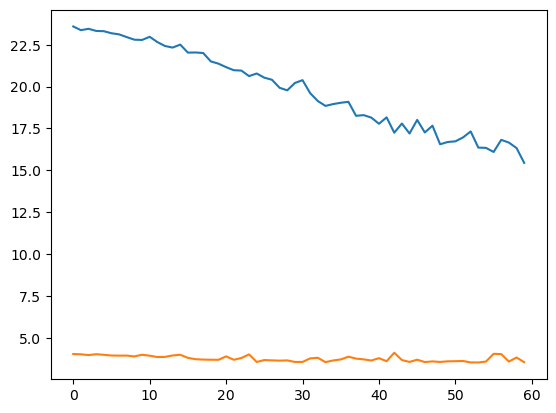

In [8]:
plt.figure()
plt.plot(np.arange(total_epochs),losses)
plt.plot(np.arange(total_epochs),val_losses)
plt.show()

In [9]:
np.argmin(val_losses)

53

In [10]:
test_dataset = TensorDataset(torch.from_numpy(X_test).type(torch.FloatTensor), torch.tensor(y_test))
test_loader = DataLoader(test_dataset,batch_size=5) 

In [11]:
num_correct = 0
true_neg = 0
model_out.eval()
with torch.no_grad():
    for batch, (val_inputs, val_labs) in enumerate(test_loader):
        val_outputs = model_out(val_inputs).detach().numpy()
        val_outputs = (val_outputs[:,1]>val_outputs[:,0]).astype(int)
        num_correct += np.sum(val_labs.numpy()[:,1].flatten() * val_outputs.flatten())
        true_neg += np.sum(val_labs.numpy()[:,0].flatten() * (1-val_outputs.flatten()))
            # num_correct+=np.argwhere([:,1] ==val_labs.numpy()[:,1]).flatten().shape[0]
acc = num_correct / np.sum(y_test[:,1])
tn_rate = true_neg / np.sum(y_test[:,0])
print("Sensitivity: "+str(acc))
print("Specificity: "+str(tn_rate))

Sensitivity: 0.47058823529411764
Specificity: 0.90625


### 84 Channels

In [14]:
class Net_result(nn.Module):
    def __init__(self):
        super().__init__() # 84 x 10 x 240
        self.conv1 = nn.Conv2d(84, 32, (1,2),stride=(1,2)) # 32 x 10 x 120 
        self.pool = nn.MaxPool2d(2) # 32 x 5 x 60
        self.conv2 = nn.Conv2d(32, 16, 2,stride=(1,2)) # 16 x 4 x 30 
        self.drop = nn.Dropout(p=0.15)
        self.fc1 = nn.Linear( 1920, 360)   
        self.fc2 = nn.Linear(360, 120)
        self.fc3 = nn.Linear(120, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = torch.flatten(x,1) 
        x = self.drop(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x

In [15]:
def retrieve_images(fil_dir, shape=(7,40,500)):
    sample_list = sorted(os.listdir(fil_dir))
    img_list = np.zeros((len(sample_list),shape[0],shape[1],shape[2]))
    ind = 0
    for file_name in sample_list:
        img_list[ind,:,:,:] = np.load(os.path.join(fil_dir,file_name))
        ind+=1
    return img_list[:ind,:,:,:]

In [16]:
fil_dir = "C:/Users/laure/Documents/proj_loopr/channeled_window_results"
xs = retrieve_images(fil_dir, shape=(84,10,240))
name_list = sorted(os.listdir("C:/Users/laure/Documents/proj_loopr/processed_images"))
ys = [1. if el[5:8]=="000" else 0. for el in name_list]
ys = np.array(ys).reshape((-1,1))
ys = np.hstack((ys, 1-ys))

In [17]:
test_split = 0.2
val_split=0.15
X_train, X_test, y_train, y_test = train_test_split(xs, ys, test_size=test_split, random_state=81)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_split, random_state=81)


In [18]:
model_out = Net_result()
criterion  = nn.CrossEntropyLoss() 
learning_rate=5e-5
optimizer = optim.Adam(model_out.parameters(), lr=learning_rate)

train_dataset = TensorDataset(torch.from_numpy(X_train).type(torch.FloatTensor), torch.tensor(y_train))
train_loader = DataLoader(train_dataset,batch_size=5,sampler = RandomSampler(train_dataset, replacement=False)) 
val_dataset = TensorDataset(torch.from_numpy(X_val).type(torch.FloatTensor), torch.tensor(y_val))
val_loader = DataLoader(val_dataset, batch_size=5)

In [19]:
total_epochs = 50
losses = np.zeros(total_epochs)
val_losses = np.zeros(total_epochs)
for epoch in range(total_epochs):  # loop over the dataset multiple times
    model_out.train()
    running_loss = 0.0

    # rand_list = np.arange(mask_list.shape[0])
    # np.random.shuffle(rand_list)

    # new_img_list = img_list[rand_list,:,:]
    # new_labels = labels[rand_list,:]
    
    for batch, (inputs, lab) in enumerate(train_loader):

        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model_out(inputs)
        loss = criterion(outputs, lab)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        # if i % 2000 == 1999:    # print every 2000 mini-batches
        #     print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
        #     running_loss = 0.0 
    
    with torch.no_grad():
        model_out.eval()
        for batch, (val_inputs, val_labs) in enumerate(val_loader):#val_sample in test_loader:
            val_outputs = model_out(val_inputs)
            valloss = criterion(val_outputs, val_labs)
            val_losses[epoch] +=valloss.item()

    print("Epoch "+str(epoch+1)+": /n Training Loss is: "+str(running_loss))
    print(" Validation Loss is: "+str(val_losses[epoch] ))
    losses[epoch] = running_loss
print('Finished Training')

Epoch 1: /n Training Loss is: 23.23914813399315
 Validation Loss is: 3.7519404947757717
Epoch 2: /n Training Loss is: 21.166128897666933
 Validation Loss is: 3.4903283774852754
Epoch 3: /n Training Loss is: 19.89385886788368
 Validation Loss is: 3.3081190407276155
Epoch 4: /n Training Loss is: 18.466614210605623
 Validation Loss is: 3.1517458617687226
Epoch 5: /n Training Loss is: 17.951201117038725
 Validation Loss is: 3.0488849401473996
Epoch 6: /n Training Loss is: 16.890938675403596
 Validation Loss is: 2.9572150290012362
Epoch 7: /n Training Loss is: 16.443524795770646
 Validation Loss is: 2.8434070587158202
Epoch 8: /n Training Loss is: 16.30530675053597
 Validation Loss is: 2.8594609141349796
Epoch 9: /n Training Loss is: 15.777585625648497
 Validation Loss is: 2.7884582817554473
Epoch 10: /n Training Loss is: 15.111844134330752
 Validation Loss is: 2.6853648483753205
Epoch 11: /n Training Loss is: 14.971563577651983
 Validation Loss is: 2.643307441473007
Epoch 12: /n Training L

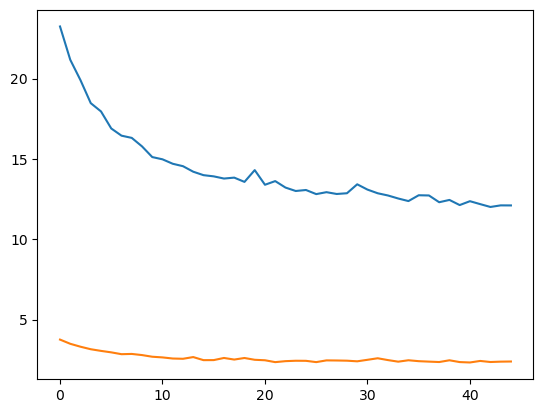

In [20]:
plt.figure()
plt.plot(np.arange(total_epochs),losses)
plt.plot(np.arange(total_epochs),val_losses)
plt.show()

In [21]:
np.argmin(val_losses)

40

In [22]:
test_dataset = TensorDataset(torch.from_numpy(X_test).type(torch.FloatTensor), torch.tensor(y_test))
test_loader = DataLoader(test_dataset,batch_size=5) 

In [23]:
num_correct = 0
true_neg = 0
model_out.eval()
with torch.no_grad():
    for batch, (val_inputs, val_labs) in enumerate(test_loader):
        val_outputs = model_out(val_inputs).detach().numpy()
        val_outputs = (val_outputs[:,1]>val_outputs[:,0]).astype(int)
        num_correct += np.sum(val_labs.numpy()[:,1].flatten() * val_outputs.flatten())
        true_neg += np.sum(val_labs.numpy()[:,0].flatten() * (1-val_outputs.flatten()))
            # num_correct+=np.argwhere([:,1] ==val_labs.numpy()[:,1]).flatten().shape[0]
acc = num_correct / np.sum(y_test[:,1])
tn_rate = true_neg / np.sum(y_test[:,0])
print("Sensitivity: "+str(acc))
print("Specificity: "+str(tn_rate))

Sensitivity: 0.7058823529411765
Specificity: 0.78125
